# クラウドファンディング成功/失敗を予測〜Kickstarter Project〜

- Day 1 から Day 4 にかけて、クラウドファウンディングの結果を予測するモデルを生成してきた。
- Kickstarter Projects(URL: https://www.kaggle.com/kemical/kickstarter-projects)
- さまざまな機械学習の手法を用いて、新しく立ち上げるクラウドファウンディングの結果予測を行うアルゴリズムを生成する

・ID：クラウドファンディングの個別ID

・name：クラウドファンディングの名前

・category：詳細なカテゴリー

・main_category：大まかなカテゴリー

・currency ：使用された通貨

・deadline：締め切り日時

・goal：目標調達資金額

・launched：開始した日時

・pledged：集まった資金

・state：プロジェクトの状態(成功、失敗、キャンセルなど)

・backer：集まった支援者

・country：プロジェクトが開かれた国

・usd pledged： 集まった資金の米ドル換算

・usd_pledged_real：実際に集まった資金の米ドル換算

・usd_goal_real：目標調達資金額"goal"の米ドル換算

In [29]:
# import libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.model_selection import KFold # 交差検証法に関する関数
from sklearn.metrics import mean_absolute_error # 回帰問題における性能評価に関する関数
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#回帰問題用
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

# 実行に影響のないWarningを非表示にする
import warnings
warnings.filterwarnings('ignore')

In [2]:
# loading the data
df = pd.read_csv('./data/ks-projects-201801.csv', index_col='ID')
df.head()

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
ID,,,,,,,,,,,,,,
1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


### 1.基礎集計

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378661 entries, 1000002330 to 999988282
Data columns (total 14 columns):
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(1), object(8)
memory usage: 43.3+ MB


In [21]:
#データの平均, 標準偏差, 最大値, 最小値などを集計
df.describe()

,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


/Users/Mayu.T/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:290: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


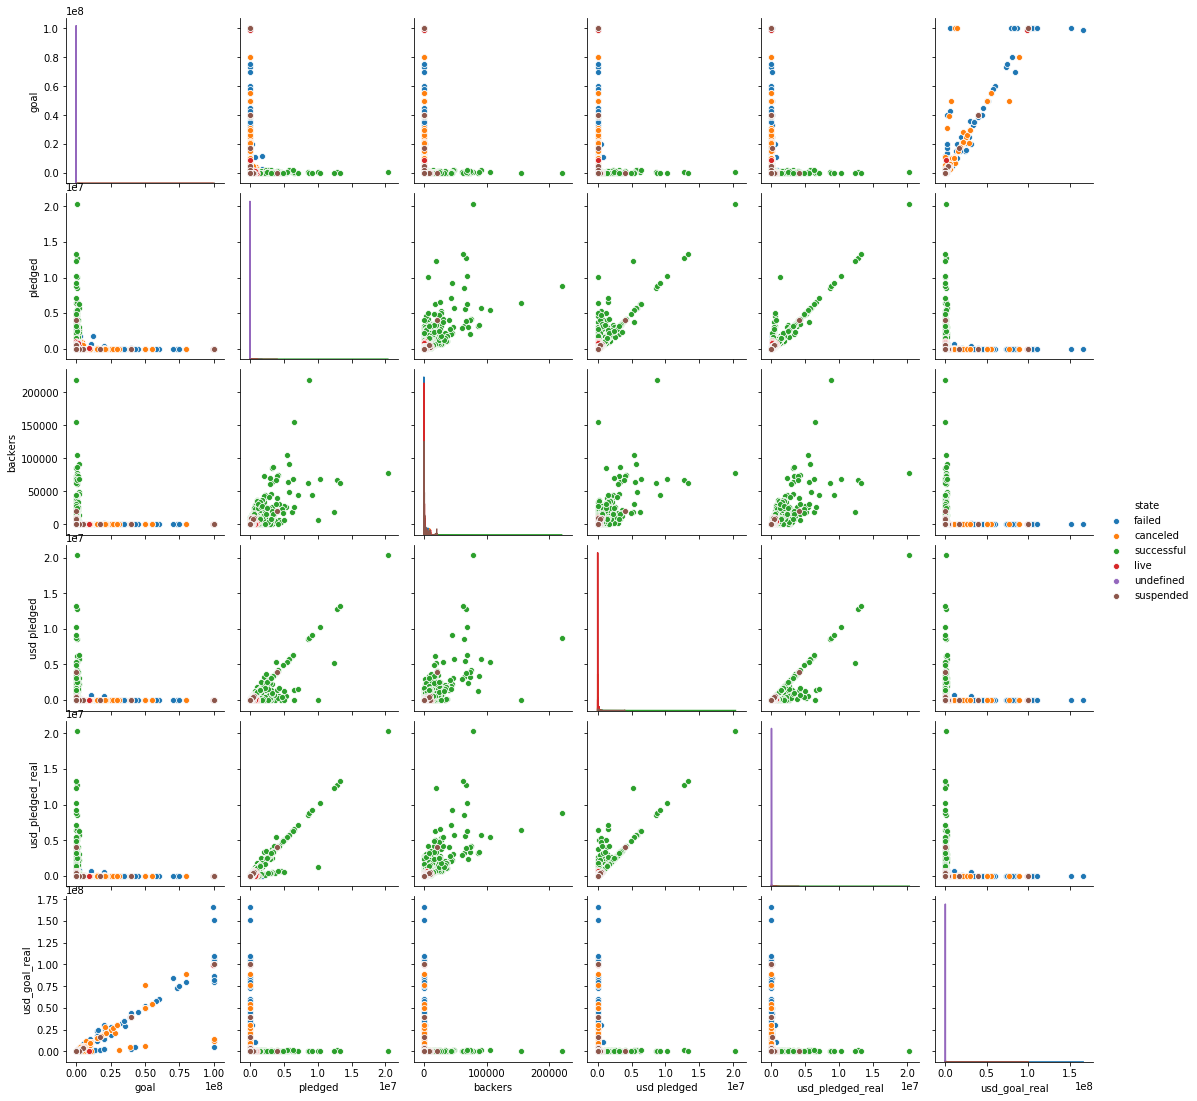

In [5]:
# data visualization
sns.pairplot(df, hue="state")

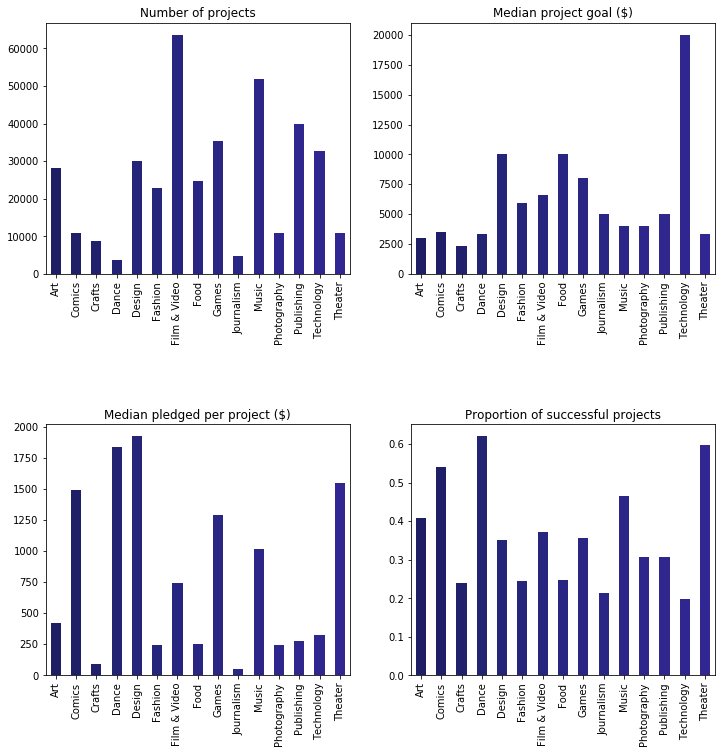

In [15]:
# プロジェクトのカテゴリーごと図示する

# Creating a dataframe grouped by category with columns for failed and successful
cat_df = pd.get_dummies(df.set_index('main_category').state).groupby('main_category').sum()
# Plotting
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,12))
color = cm.CMRmap(np.linspace(0.1,0.8,df.category.nunique()))
df.groupby('main_category').category.count().plot(kind='bar', ax=ax1, color=color)
ax1.set_title('Number of projects')
ax1.set_xlabel('')
df.groupby('main_category').usd_goal_real.median().plot(kind='bar', ax=ax2, color=color)
ax2.set_title('Median project goal ($)')
ax2.set_xlabel('')
df.groupby('main_category').usd_pledged_real.median().plot(kind='bar', ax=ax3, color=color)
ax3.set_title('Median pledged per project ($)')
ax3.set_xlabel('')
cat_df.div(cat_df.sum(axis=1), axis=0).successful.plot(kind='bar', ax=ax4, color=color) # Normalizes counts across rows
ax4.set_title('Proportion of successful projects')
ax4.set_xlabel('')


fig.subplots_adjust(hspace=0.6)
plt.show()

### 2.目的変数と説明変数を決める

- 目的変数は`state`からみるクラウドファウンディングプロジェクトの結果。成功/失敗を予測したい。

In [22]:
#目的変数
df['state'].value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

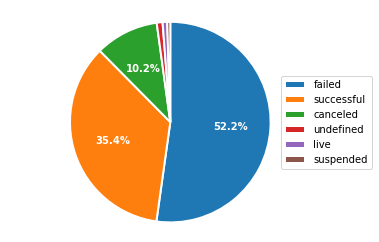

In [23]:
#グラフを描く
per_state = round(df['state'].value_counts() / len(df['state']) * 100,2)
values = list(per_state.values)

# 円グラフ
plt.figure(figsize=(4,4))
plt.pie(values, labels=list(per_state.index),
        wedgeprops={'linewidth': 2,'edgecolor':'white'},
        textprops={'color': 'white', 'weight': 'bold'},
        counterclock=False,startangle=90,
        autopct=lambda p: '{:.1f}%'.format(p) if p >= 2.5 else '')
lgnd=plt.legend(bbox_to_anchor=(1.0, 0.25, 1.55, 0.5), loc="center left", borderaxespad=0.)
plt.axis('equal')
plt.show()

In [24]:
for i in df.columns:
    print('column名:{}, Dtype:{}, カテゴリ数:{}個'.format(i, df[i].dtype, len(df[i].value_counts())))

column名:name, Dtype:object, カテゴリ数:375764個
column名:category, Dtype:object, カテゴリ数:159個
column名:main_category, Dtype:object, カテゴリ数:15個
column名:currency, Dtype:object, カテゴリ数:14個
column名:deadline, Dtype:object, カテゴリ数:3164個
column名:goal, Dtype:float64, カテゴリ数:8353個
column名:launched, Dtype:object, カテゴリ数:378089個
column名:pledged, Dtype:float64, カテゴリ数:62130個
column名:state, Dtype:object, カテゴリ数:6個
column名:backers, Dtype:int64, カテゴリ数:3963個
column名:country, Dtype:object, カテゴリ数:23個
column名:usd pledged, Dtype:float64, カテゴリ数:95455個
column名:usd_pledged_real, Dtype:float64, カテゴリ数:106065個
column名:usd_goal_real, Dtype:float64, カテゴリ数:50339個


[Discussion]
Pledge > Goals means the kick-starter has raised enough funds so it's successful. So at least don't use the pledge column.
Pledgeを使うとリークにつながるので, 使うなというDiscussionがあった
URL:https://www.kaggle.com/kemical/kickstarter-projects/discussion/170598

結果より, 説明変数は, 
- `main_category(object)`
- `currency(object)`
- `goal`
- `usd_goal_real`
を用いることにする

### 3.欠損値の処理 & データの前処理

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378661 entries, 1000002330 to 999988282
Data columns (total 14 columns):
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(1), object(8)
memory usage: 43.3+ MB


In [17]:
# 期間の変数を作成
df['deadline'] = pd.to_datetime(df['deadline'])
df['launched'] = pd.to_datetime(df['launched'])
df['days'] = (df['deadline'] - df['launched']).dt.days

In [18]:
df = df.drop(columns=['deadline', 'launched'])
df.head()

,name,category,main_category,currency,goal,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,days
ID,,,,,,,,,,,,,
1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,1000.0,0.0,failed,0,GB,0.0,0.0,1533.95,58
1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,30000.0,2421.0,failed,15,US,100.0,2421.0,30000.00,59
1000004038,Where is Hank?,Narrative Film,Film & Video,USD,45000.0,220.0,failed,3,US,220.0,220.0,45000.00,44
1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,5000.0,1.0,failed,1,US,1.0,1.0,5000.00,29
1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,19500.0,1283.0,canceled,14,US,1283.0,1283.0,19500.00,55


In [19]:
df = df.drop(columns=['name','category','pledged','backers','usd pledged','usd_pledged_real'])

In [20]:
df = df.dropna(axis=0)

In [21]:
X_df = df[["main_category", "currency", "country","days","goal", "usd_goal_real"]]
y_df = df["state"].map({df['state'].unique()[0]:0, df['state'].unique()[1]:1, df['state'].unique()[2]:2,\
                        df['state'].unique()[3]:3,df['state'].unique()[4]:4,df['state'].unique()[5]:5})
display(X_df.head())
X_df.info()

,main_category,currency,country,days,goal,usd_goal_real
ID,,,,,,
1000002330,Publishing,GBP,GB,58,1000.0,1533.95
1000003930,Film & Video,USD,US,59,30000.0,30000.00
1000004038,Film & Video,USD,US,44,45000.0,45000.00
1000007540,Music,USD,US,29,5000.0,5000.00
1000011046,Film & Video,USD,US,55,19500.0,19500.00


<class 'pandas.core.frame.DataFrame'>
Int64Index: 378661 entries, 1000002330 to 999988282
Data columns (total 6 columns):
main_category    378661 non-null object
currency         378661 non-null object
country          378661 non-null object
days             378661 non-null int64
goal             378661 non-null float64
usd_goal_real    378661 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 20.2+ MB


In [22]:
X_df.isnull().sum()

main_category    0
currency         0
country          0
days             0
goal             0
usd_goal_real    0
dtype: int64

In [34]:
# handling heterogeneous data
for col, dtype in df.dtypes.items():
    if dtype == 'object':
        print(col)
        display(df[col].value_counts())

main_category


Film & Video    63585
Music           51918
Publishing      39874
Games           35231
Technology      32569
Design          30070
Art             28153
Food            24602
Fashion         22816
Theater         10913
Comics          10819
Photography     10779
Crafts           8809
Journalism       4755
Dance            3768
Name: main_category, dtype: int64

currency


USD    295365
GBP     34132
EUR     17405
CAD     14962
AUD      7950
SEK      1788
MXN      1752
NZD      1475
DKK      1129
CHF       768
NOK       722
HKD       618
SGD       555
JPY        40
Name: currency, dtype: int64

state


failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

In [25]:
#前処理(ダミー変数化)
X_df = pd.get_dummies(X_df)
print(len(y_df))

378661


In [26]:
# 前処理後のデータフレームの概要
X_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378661 entries, 1000002330 to 999988282
Data columns (total 55 columns):
days                          378661 non-null int64
goal                          378661 non-null float64
usd_goal_real                 378661 non-null float64
main_category_Art             378661 non-null uint8
main_category_Comics          378661 non-null uint8
main_category_Crafts          378661 non-null uint8
main_category_Dance           378661 non-null uint8
main_category_Design          378661 non-null uint8
main_category_Fashion         378661 non-null uint8
main_category_Film & Video    378661 non-null uint8
main_category_Food            378661 non-null uint8
main_category_Games           378661 non-null uint8
main_category_Journalism      378661 non-null uint8
main_category_Music           378661 non-null uint8
main_category_Photography     378661 non-null uint8
main_category_Publishing      378661 non-null uint8
main_category_Technology      378661 non-

### 4.連続変数の可視化及び異常値の処理
- seaborn の pairplot によって散布図行列を描画する

/Users/Mayu.T/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


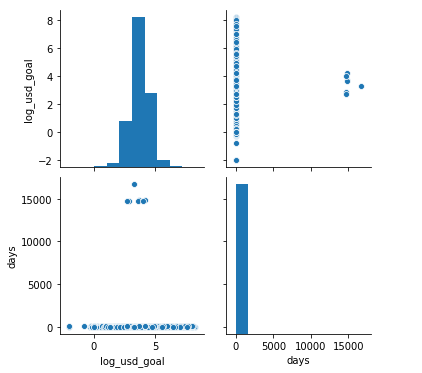

In [7]:
epsilon = 1e-5 # 対数変換の際に負の無限大に発散しないようにフロアリングするパラメータ
X_df['log_usd_goal'] = X_df['usd_goal_real'].apply(lambda x: np.log10(x + epsilon))

sns.pairplot(X_df[['log_usd_goal', 'days']])
plt.show()

グラフから、平均値に大きな外れ値が入っているため標準化しておく。

In [25]:
# 標準化
scaler = StandardScaler()
X_std = scaler.fit_transform(X_df)

X_std = (X_df - X_df.mean(axis=0)) / X_df.std(axis=0)

/Users/Mayu.T/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/Mayu.T/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


### 5.Modeling


- K-means 
- 主成分分析

In [41]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
# クラスタリング
clf = KMeans(n_clusters=len(y_df.unique()))
clf.fit(X_std)
y_pred = clf.predict(X_std)
print(y_pred)
print(clf.cluster_centers_)

[3 0 0 ... 0 5 0]
[[-1.80441701e-02 -1.73055616e-02 -1.59495836e-03  8.95961500e-02
   5.78654144e-02  4.25289866e-02  4.09863268e-02  6.38643051e-02
  -2.53214937e-01  1.35484730e-01  8.91735457e-02 -3.20289993e-01
   2.94575423e-02  1.59685730e-01  4.32845313e-02  1.05623019e-01
  -3.06765441e-01  4.76253617e-02 -1.46442059e-01 -1.06160434e-02
  -8.14486171e-03 -3.05811452e-03 -4.39848775e-02 -3.14751622e-01
  -9.87125522e-03 -6.15366524e-03  4.15769498e-03 -3.57443349e-03
  -1.42092147e-03 -3.62879394e-04 -7.83957889e-03  2.98613676e-01
  -3.37780225e-01  7.44219506e-02 -4.63671201e-03  1.32260381e-01
  -1.41202566e-02  3.49996689e-02]
 [ 8.23495750e-03  7.92200093e-04  1.86243867e-01 -7.93036153e-02
  -2.96625511e-02 -1.73839159e-03 -5.97314758e-02  1.38625419e-01
   1.25510758e-01 -1.21380782e-01 -2.03521513e-02  9.55225544e-02
   1.02640722e-02 -2.06770910e-01  4.49886093e-02  8.27679836e-03
   2.37457065e-01 -1.15918074e-01  6.82250233e+00 -2.02826068e-01
  -4.22875038e-02 -5.46

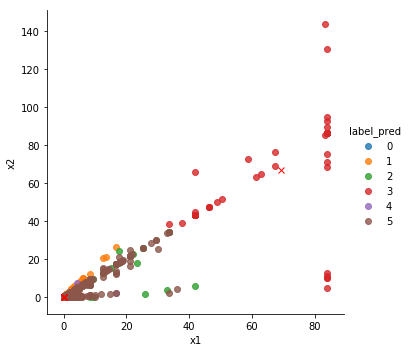

In [21]:
# クラスタリング結果の描画, 赤×は中心点
df_data = pd.DataFrame(X_std[:, :2], columns=["x1","x2"])
df_data["label_pred"] = y_pred
sns.lmplot(x="x1", y="x2", hue="state", data=df_data,fit_reg=False)
plt.plot(clf.cluster_centers_[:,0],clf.cluster_centers_[:,1], marker="x",ls="",color="r")

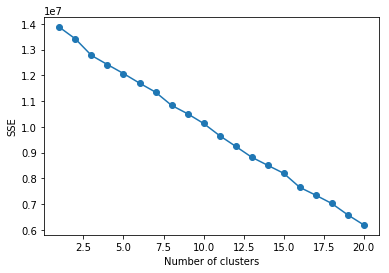

In [22]:
#エルボー図
def plot_elbow(X, sta_k, end_k):
    sse = []
    for i in range(sta_k, end_k+1):
        clf = KMeans(n_clusters=i,random_state=1234)
        clf.fit(X)
        sse.append(clf.inertia_)

    plt.plot(range(sta_k, end_k+1), sse, marker="o")
    plt.xlabel("Number of clusters")
    plt.ylabel("SSE")
    plt.show()
    
plot_elbow(X_std, 1, 20)

きれいに「ひじ」が表れなかった。

### 主成分分析の実行

In [27]:
from sklearn.decomposition import PCA

df_pca = PCA(n_components=len(X_df.columns)) #主成分分析用のオブジェクトをつくる。削減後の次元数を引数で指定する。
df_pca.fit(X_df)

PCA(copy=True, iterated_power='auto', n_components=55, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [29]:
print("-- 固有ベクトル（重み係数W） --")
print(df_pca.components_)

-- 固有ベクトル（重み係数W） --
[[ 1.74708898e-07  7.16811402e-01  6.97267104e-01 ...  3.60331054e-10
  -2.25243172e-11 -1.34260636e-09]
 [ 9.05538598e-08  6.97267104e-01 -7.16811402e-01 ...  1.22597782e-08
   4.10035156e-11 -2.47257060e-08]
 [ 9.99999922e-01 -1.88395883e-07 -5.69196613e-08 ... -1.13475795e-06
  -6.82871575e-07  4.64137631e-05]
 ...
 [-0.00000000e+00 -1.64704585e-21  1.77792638e-21 ...  1.78525673e-01
   1.20650600e-01  1.78525673e-01]
 [ 0.00000000e+00  9.02983961e-23 -9.67394631e-23 ... -3.02162229e-02
  -6.54861377e-01 -3.02162229e-02]
 [ 0.00000000e+00 -4.24204714e-23  4.32156859e-23 ... -6.54757065e-04
   7.29083190e-03 -6.54757065e-04]]


In [30]:
print("固有値（主成分の分散）=",df_pca.explained_variance_)
print("寄与率=",df_pca.explained_variance_ratio_)
print("合計＝", df_pca.explained_variance_ratio_.sum())

固有値（主成分の分散）= [2.65154613e+12 7.81625678e+10 4.34393811e+03 5.41874323e-01
 4.35686504e-01 1.57249831e-01 1.26096345e-01 1.18740885e-01
 9.87847630e-02 8.90242143e-02 8.18832122e-02 7.29633774e-02
 6.78754852e-02 6.57023019e-02 6.15117466e-02 4.45692141e-02
 3.45747705e-02 2.86708623e-02 2.84677564e-02 2.39448699e-02
 1.53416870e-02 1.33656600e-02 1.16549901e-02 1.03845576e-02
 1.00008834e-02 9.27701359e-03 8.10611156e-03 7.70128715e-03
 7.58546919e-03 6.34618532e-03 6.29463638e-03 4.52639078e-03
 3.86635921e-03 3.39149665e-03 3.01316219e-03 2.57287557e-03
 1.83400789e-03 1.60003173e-03 1.13047227e-03 3.78060109e-04
 2.26148212e-04 1.95871183e-04 1.78477780e-04 9.67652497e-05
 4.34762262e-05 3.80337262e-05 2.28720037e-05 1.91373403e-05
 9.79625676e-06 2.64666021e-20 2.64666021e-20 2.64666021e-20
 2.64666021e-20 2.64666021e-20 2.64666021e-20 2.64666021e-20]
寄与率= [9.71365966e-01 2.86340325e-02 1.59135592e-09 1.98509944e-13
 1.59609157e-13 5.76068173e-14 4.61940663e-14 4.34994712e-14
 3.61

### ベイズ最適化 (ハイパーパラメータチューニング)

まずは optuna をインストールする

In [2]:
pip install optuna

    100% |████████████████████████████████| 317kB 7.9MB/s ta 0:00:011
    100% |████████████████████████████████| 81kB 9.0MB/s eta 0:00:01
    100% |████████████████████████████████| 40kB 11.1MB/s ta 0:00:01
    100% |████████████████████████████████| 215kB 9.6MB/s eta 0:00:01
    100% |████████████████████████████████| 122kB 12.3MB/s ta 0:00:01
    100% |████████████████████████████████| 51kB 14.6MB/s ta 0:00:01
    100% |████████████████████████████████| 153kB 9.4MB/s ta 0:00:011
    100% |████████████████████████████████| 81kB 11.2MB/s ta 0:00:01
  Stored in directory: /Users/Mayu.T/Library/Caches/pip/wheels/25/af/b8/3407109267803f4015e1ee2ff23be0c8c19ce4008665931ee1
Successfully built pyperclip
stevedore 3.5.0 has requirement importlib-metadata>=1.7.0; python_version < "3.8", but you'll have importlib-metadata 0.0.0 which is incompatible.
cmd2 2.2.0 has requirement importlib-metadata>=1.6.0; python_version < "3.8", but you'll have importlib-metadata 0.0.0 which is incompatible.
imp

In [4]:
import optuna

# 最小化したい目的関数（1試行ごとに行う処理）
def objective(trial):
    x = trial.suggest_float("x", -10, 10)
    return (x - 2) ** 2

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

ImportError: cannot import name 'EntryPoint' from 'importlib_metadata' (/Users/Mayu.T/anaconda3/lib/python3.7/site-packages/importlib_metadata/__init__.py)